In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2323, testing examples = 259


In [3]:
df["prob_of_release"] = df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
train_df["prob_of_release"] = train_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
test_df["prob_of_release"] = test_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)

## Model-Building and Evaluation

In [4]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    # pm.Beta("y_pred", alpha=p, beta=(1 - p), shape=features.shape[1], observed=train_df["prob_of_release"])
    pm.TruncatedNormal("y_pred", mu=p, sigma=error, observed=train_df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [5]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


In [6]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.59,0.03,0.54,0.65,0.00,0.00,2164.88,2140.67,1.0
M_Sep,0.26,0.30,-0.30,0.84,0.01,0.01,945.27,1415.76,1.0
month_holidays,0.20,0.06,0.08,0.32,0.00,0.00,2312.63,2522.55,1.0
M_May,0.05,0.30,-0.51,0.62,0.01,0.01,919.68,1364.41,1.0
M_Jan,-0.00,0.31,-0.60,0.56,0.01,0.01,922.60,1435.20,1.0
M_Jul,-0.02,0.31,-0.62,0.52,0.01,0.01,918.70,1297.47,1.0
M_Jun,-0.06,0.30,-0.66,0.47,0.01,0.01,930.25,1288.58,1.0
M_Oct,-0.07,0.31,-0.62,0.52,0.01,0.01,925.75,1386.68,1.0
M_Aug,-0.08,0.32,-0.68,0.50,0.01,0.01,989.92,1455.67,1.0


### Out-of-Sample Evaluation

In [7]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [8]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [9]:
mape(test_df["prob_of_release"], y_pred)

0.27503793034222945

In [10]:
wape(test_df["prob_of_release"], y_pred)

0.23489980379206907

## Predictions for the Next Month

In [11]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.TruncatedNormal("y_pred", mu=p, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [12]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [13]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.59,0.03,0.54,0.64,0.00,0.00,2407.06,2487.19,1.00
month_holidays,0.18,0.07,0.06,0.30,0.00,0.00,1966.73,1394.08,1.00
M_Sep,0.17,0.30,-0.41,0.71,0.01,0.01,775.80,1351.81,1.00
M_Jul,-0.00,0.31,-0.57,0.57,0.01,0.01,811.47,1178.86,1.00
M_Jan,0.00,0.31,-0.59,0.53,0.01,0.01,828.89,1305.49,1.00
M_Aug,-0.01,0.32,-0.59,0.60,0.01,0.01,811.39,1427.27,1.00
M_May,-0.02,0.30,-0.58,0.54,0.01,0.01,779.90,1296.61,1.00
WD_Friday,-0.07,0.36,-0.73,0.62,0.01,0.01,692.09,871.63,1.01
WD_Thursday,-0.09,0.36,-0.79,0.57,0.01,0.01,675.32,919.30,1.01


In [14]:
with model:
    pm.set_data({"features" : next_month[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


In [15]:
next_month["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [16]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_month["predicted_min"] = hdi["y_pred"][:, 0]
next_month["predicted_max"] = hdi["y_pred"][:, 1]

In [17]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
3,2024-03-17,0.0071,0.4094,0.7553
4,2024-03-18,0.1751,0.5485,0.9602
5,2024-03-19,0.3312,0.6704,0.9964
6,2024-03-20,0.4441,0.7491,0.9998
7,2024-03-21,0.4993,0.7854,1.0000
8,2024-03-22,0.5366,0.8051,1.0000
9,2024-03-23,0.5444,0.8121,1.0000
10,2024-03-24,0.5431,0.8133,1.0000
11,2024-03-25,0.5507,0.8170,1.0000
12,2024-03-26,0.5739,0.8256,0.9999


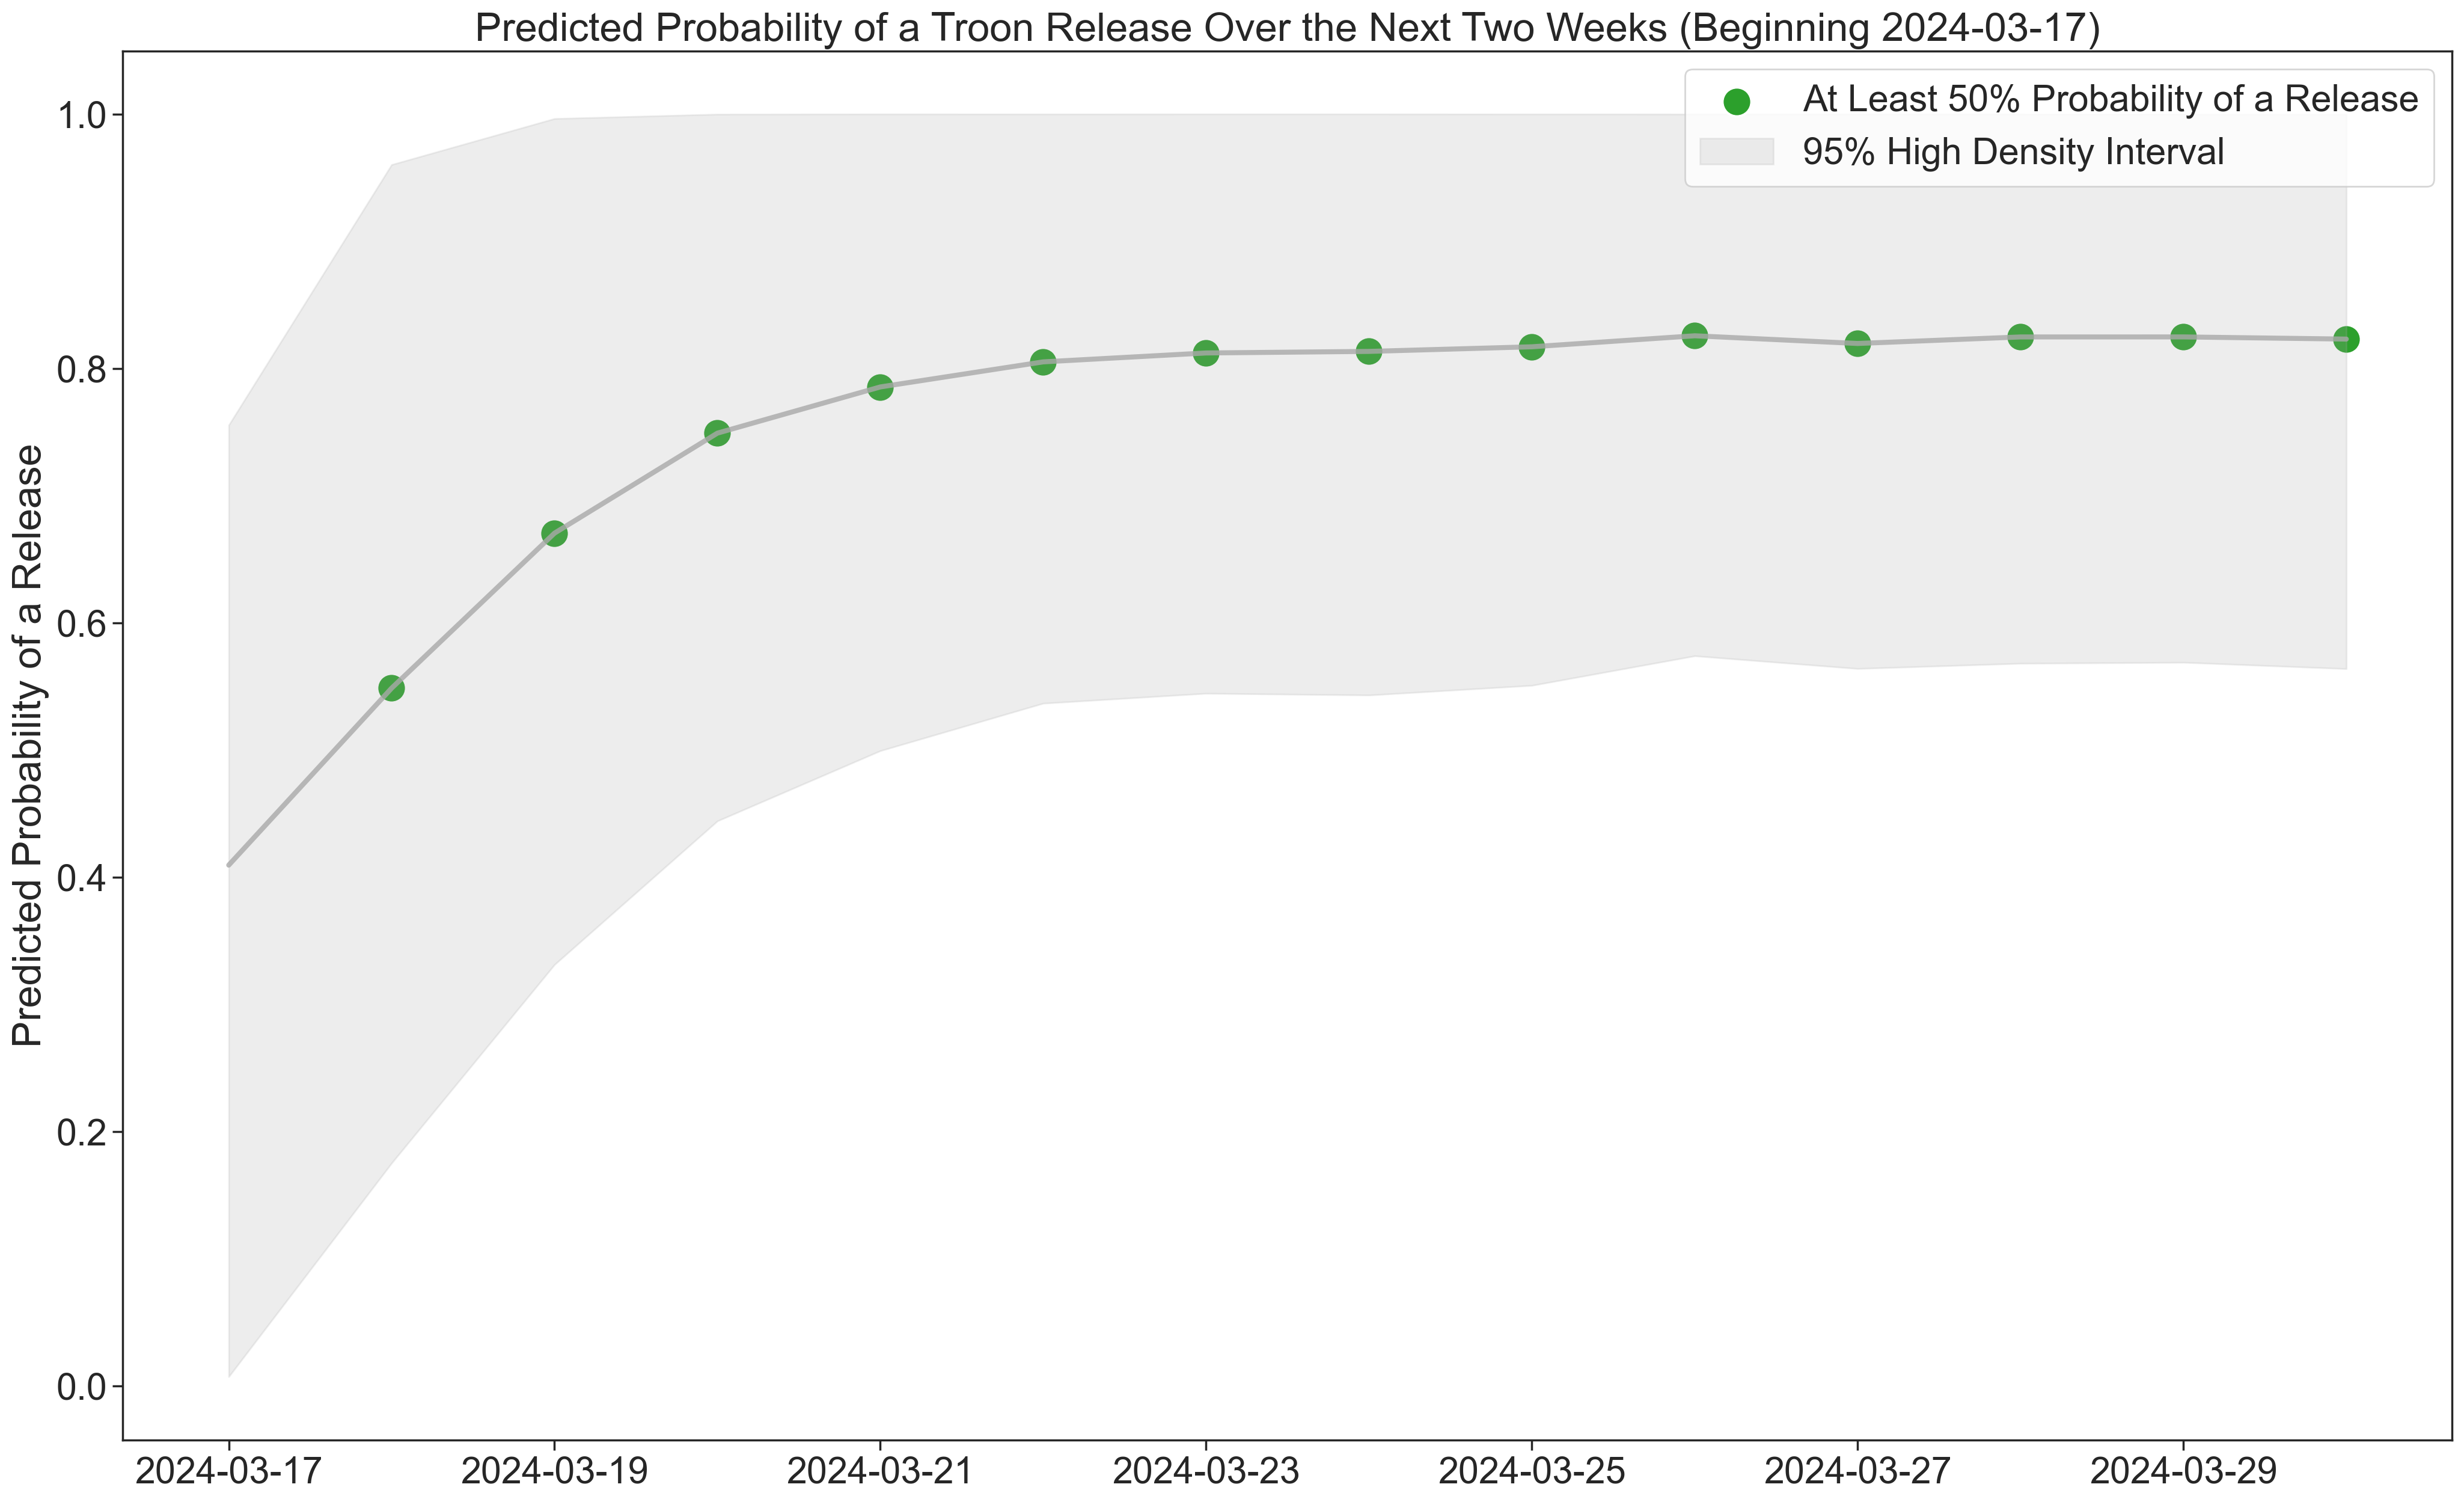

In [18]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()